In [1]:
import gc
import time
import keras as k
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import mean_squared_error, accuracy_score, \
                            confusion_matrix, classification_report

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Inspecting Data

In [2]:
df = pd.read_csv('../data/old/zscore_btc.csv',index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 837 entries, 7/10/2016 to 10/24/2018
Columns: 139 entries, com_count to bitcoin_close
dtypes: float64(139)
memory usage: 915.5+ KB


In [3]:
df.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,sub_title_non_zero_pr,sub_title_top_50_pr,sub_title_top_75_pr,sub_title_pr_4_bins,sub_title_pr_normalized,sub_title_pr_norm_plus_base,sub_title_pos_non_zero_pr,sub_title_pos_top_50_pr,sub_title_pos_top_75_pr,sub_title_pos_pr_4_bins,sub_title_pos_pr_normalized,sub_title_pos_pr_norm_plus_base,sub_title_very_pos_non_zero_pr,sub_title_very_pos_top_50_pr,sub_title_very_pos_top_75_pr,sub_title_very_pos_pr_4_bins,sub_title_very_pos_pr_normalized,sub_title_very_pos_pr_norm_plus_base,sub_title_neg_non_zero_pr,sub_title_neg_top_50_pr,sub_title_neg_top_75_pr,sub_title_neg_pr_4_bins,sub_title_neg_pr_normalized,sub_title_neg_pr_norm_plus_base,sub_title_very_neg_non_zero_pr,sub_title_very_neg_top_50_pr,sub_title_very_neg_top_75_pr,sub_title_very_neg_pr_4_bins,sub_title_very_neg_pr_normalized,sub_title_very_neg_pr_norm_plus_base,sub_title_very_pos_minus_very_neg_non_zero_pr,sub_title_pos_minus_neg_non_zero_pr,sub_title_pos_non_zero_pr_percent,sub_title_very_pos_non_zero_pr_percent,sub_title_neg_non_zero_pr_percent,sub_title_very_neg_non_zero_pr_percent,sub_body_non_zero_pr,sub_body_top_50_pr,sub_body_top_75_pr,sub_body_pr_4_bins,sub_body_pr_normalized,sub_body_pr_norm_plus_base,sub_body_pos_non_zero_pr,sub_body_pos_top_50_pr,sub_body_pos_top_75_pr,sub_body_pos_pr_4_bins,sub_body_pos_pr_normalized,sub_body_pos_pr_norm_plus_base,sub_body_very_pos_non_zero_pr,sub_body_very_pos_top_50_pr,sub_body_very_pos_top_75_pr,sub_body_very_pos_pr_4_bins,sub_body_very_pos_pr_normalized,sub_body_very_pos_pr_norm_plus_base,sub_body_neg_non_zero_pr,sub_body_neg_top_50_pr,sub_body_neg_top_75_pr,sub_body_neg_pr_4_bins,sub_body_neg_pr_normalized,sub_body_neg_pr_norm_plus_base,sub_body_very_neg_non_zero_pr,sub_body_very_neg_top_50_pr,sub_body_very_neg_top_75_pr,sub_body_very_neg_pr_4_bins,sub_body_very_neg_pr_normalized,sub_body_very_neg_pr_norm_plus_base,sub_body_very_pos_minus_very_neg_non_zero_pr,sub_body_pos_minus_neg_non_zero_pr,sub_body_pos_non_zero_pr_percent,sub_body_very_pos_non_zero_pr_percent,sub_body_neg_non_zero_pr_percent,sub_body_very_neg_non_zero_pr_percent,com_body_non_zero_pr,com_body_top_50_pr,com_body_top_75_pr,com_body_pr_4_bins,com_body_pr_normalized,com_body_pr_norm_plus_base,com_body_pos_non_zero_pr,com_body_pos_top_50_pr,com_body_pos_top_75_pr,com_body_pos_pr_4_bins,com_body_pos_pr_normalized,com_body_pos_pr_norm_plus_base,com_body_very_pos_non_zero_pr,com_body_very_pos_top_50_pr,com_body_very_pos_top_75_pr,com_body_very_pos_pr_4_bins,com_body_very_pos_pr_normalized,com_body_very_pos_pr_norm_plus_base,com_body_neg_non_zero_pr,com_body_neg_top_50_pr,com_body_neg_top_75_pr,com_body_neg_pr_4_bins,com_body_neg_pr_normalized,com_body_neg_pr_norm_plus_base,com_body_very_neg_non_zero_pr,com_body_very_neg_top_50_pr,com_body_very_neg_top_75_pr,com_body_very_neg_pr_4_bins,com_body_very_neg_pr_normalized,com_body_very_neg_pr_norm_plus_base,com_body_very_pos_minus_very_neg_non_zero_pr,com_body_pos_minus_neg_non_zero_pr,com_body_pos_non_zero_pr_percent,com_body_very_pos_non_zero_pr_percent,com_body_neg_non_zero_pr_percent,com_body_very_neg_non_zero_pr_percent,avg_clust_coef,avg_degree,num_edges,num_nodes,com_body_pos_percent,com_body_very_pos_percent,com_body_neg_percent,com_body_very_neg_percent,sub_body_pos_percent,sub_body_very_pos_percent,sub_body_neg_percent,sub_body_very_neg_percent,sub_title_pos_percent,sub_title_very_pos_percent,sub_title_neg_percent,sub_title_very_neg_percent,bitcoin_close
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7/10/2016,-1.883750,-1.321221,-1.785986,-1.721442,-1.711227,-1.466842,-1.842558,-1.232573,-0.269408,-1.109361,-0.503556,-0.247316,-1.6465

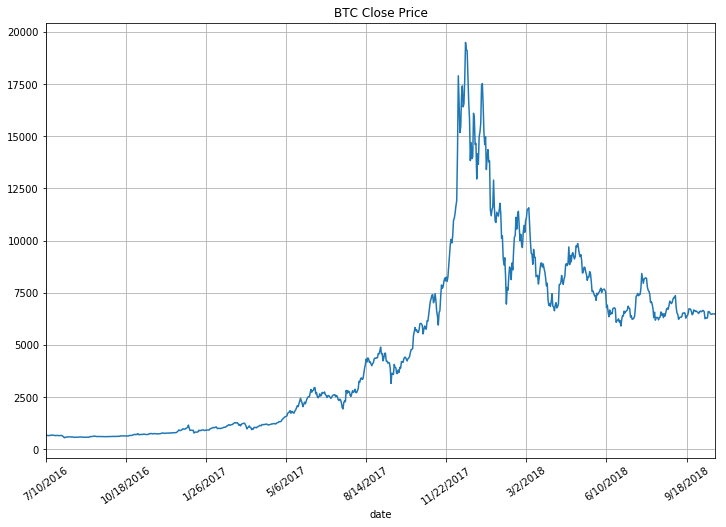

In [4]:
# show closing price time series
df['bitcoin_close'].plot(title='BTC Close Price',grid=True,rot=35, figsize=(12,8))

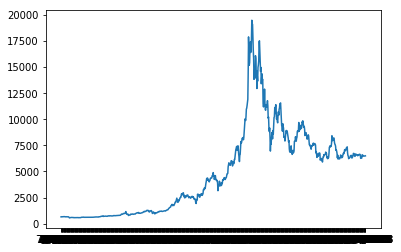

In [5]:
# show log-closing price time series
#df['bitcoin_close'].plot(title='BTC Log-Close Price',grid=True,logy=True,rot=35, figsize=(12,8))

df_btc = pd.read_csv('../data/old/zscore_btc.csv',index_col='date')
df_eth = pd.read_csv('../data/old/zscore_eth.csv',index_col='date')

plt.plot(df_btc.index, df_btc['bitcoin_close'])
plt.show()

Text(0, 0.5, 'y label')

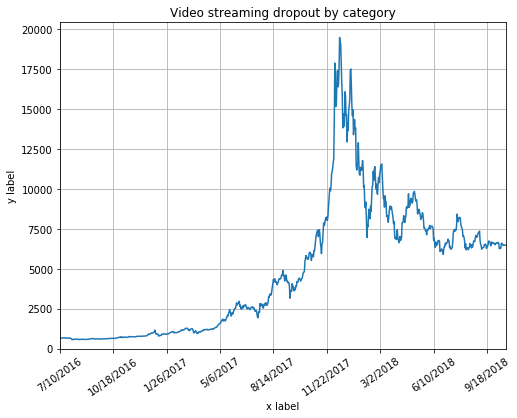

In [6]:
ax = df_btc['bitcoin_close'].plot(grid=True, title='Video streaming dropout by category', 
                 legend=False, rot=35, ylim = (0,None), figsize=(8,6))
ax.ylim = 0
ax.set_xlabel("x label")
ax.set_ylabel("y label")

In [7]:
# stats on time series length
print("number of days:  {:.1f}".format(df.shape[0]))
print("number of months:  {:.1f}".format(df.shape[0] / 30))
print("number of years:    {:.1f}".format(df.shape[0] / 365))

number of days:  837.0
number of months:  27.9
number of years:    2.3


# Defining Functions

## Loading and Preparing Data

In [8]:
# function to read in dataset

def get_data(curr='btc',data='raw'):
    if curr.lower() not in ['btc', 'eth']:
        raise ValueError('Must be BTC or ETH')
    if data.lower() not in ['raw', 'zscore']:
        raise ValueError('Must be raw or zscore')
    return pd.read_csv('../data/old/{}_{}.csv'.format(data.lower(), curr.lower()), index_col='date')

In [9]:
# function to drop unneeded fields

def keep_only_close(df_in, curr='btc'):
    if curr.lower() == 'btc':
        drops = ['bitcoin_open', 'bitcoin_high', 'bitcoin_low',
                 'bitcoin_volume', 'bitcoin_market_cap']
    elif curr.lower() == 'eth':
        drops = ['eth_open', 'eth_high', 'eth_low',
                 'eth_volume', 'eth_market_cap']
    else:
        raise ValueError('Must be BTC or ETH for lags')
    return df_in.drop(drops, axis=1) 

In [10]:
# function to add predicted column for tomorrow's close price

def add_prediction_field(df_in, curr='btc'):
    if curr.lower() == 'btc':
        name = 'bitcoin'
    elif curr.lower() == 'eth':
        name = 'eth'
    else:
        raise ValueError('Must be BTC or ETH for lags')
    
    # creating predicted value
    # create column to hold tomorrow's close for each day
    df_in['tomorrow_close'] = df_in['{}_close'.format(name)].shift(-1)
    # change in price between consecutive closing days
    df_in['day_change'] = df_in['tomorrow_close'] - df_in['{}_close'.format(name)]
    # indicator variable to be used for predicting higher/lower days
    df_in['y'] = np.where(df_in['day_change'] >= 0, 1, 0)
        
    # drop intermediate columns
    return df_in.drop(['tomorrow_close', 'day_change'], axis=1)

In [11]:
# function to retrieve lag values to use for each feature

def get_feature_lag_dict(curr='btc'):
    # check value of input
    if curr.lower() not in ['btc', 'eth']:
        raise ValueError('Must be BTC or ETH for lags')
    
    # read in right version of file
    df = pd.read_csv('../lags/optimal_lags_{}.csv'.format(curr.lower()))
    
    # return dictionary of features as keys and lags as values
    return dict(zip(df.feature, df.lags))

In [12]:
# function to add lags for daily features

def add_lags(df_in, curr='btc'):
    # splitting into X/y for separate processing
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    # save list of columns for lags
    col_list = X.columns
    # create output DF
    df_out = X.copy()
    
    # creating lags
    f_dict = get_feature_lag_dict(curr=curr)
    # create lag columns for each other variable
    for col in col_list:
        if col not in f_dict.keys(): continue
        for lag in range(int(f_dict[col])-1):
            df_out['{}_(-{})'.format(col,lag+1)] = df_out[col].shift(lag+1)
    
    # add 9 lags of 
    if curr=='btc': 
        col = 'bitcoin_close'
    elif curr=='eth':
        col = 'eth_close'
    for lag in range(9):
        df_out['{}_(-{})'.format(col,lag+1)] = df_out[col].shift(lag+1)
            
    # return and drop na
    df_out['y'] = y
    return df_out.dropna()

In [13]:
# function to remove data before certain date

def truncate_date(df_in, first_day='1999-1-1'):
    # set mask of Bool values
    mask = (pd.to_datetime(df_in.index) >= first_day)
    return df_in.loc[mask]

In [26]:
# function to rejoin training data into X/y again

def rejoin_training_data(X_train, X_test, y_train, y_test):
    Xs = [X_train, X_test]
    Ys = [y_train, y_test]
    
    df_out = pd.concat(Xs)
    df_out['y'] = pd.concat(Ys)
    
    return df_out

In [27]:
# function to create train/test X and y
def create_training_data(df_in, curr='btc', train_split=0.7, rescale=True, k_feat_perc=None):
    # split into test train
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    
    # determine cutoff of train/test split and split
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]
    
    # scale values to 0-1
    # must only scale based on training data, to ensure no 
    # foresight with averages
    if rescale:
        scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train.values)
        cols = X.columns
        X_train = pd.DataFrame(scaler.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(scaler.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # select top K features to use
    if k_feat_perc:
        selector = SelectPercentile(chi2, percentile=k_feat_perc).fit(
                                    X_train.values,y_train.values)
        # index and names of remainig columns after filter
        cols = X_train.columns[selector.get_support(indices = True)]
        X_train = pd.DataFrame(selector.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(selector.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # recreate into X/y DF and add lags
    df_renew = rejoin_training_data(X_train, X_test, y_train, y_test)
    df_renew = add_lags(df_renew, curr=curr)
    
    # split into test train again
    X, y = df_renew[df_renew.columns[:-1]], df_renew[df_renew.columns[-1]]
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]

    # display shapes
    print('='*65)
    print('New Training Set')
    print('Training Set Dims: {}'.format(X_train.shape))
    print('Testing Set Dims:  {}'.format(X_test.shape))
    print('='*65)

    return X_train, X_test, y_train, y_test

In [28]:
# function to prep data and return DF for modeling

def prepare_data(curr='btc',data='raw', train_split=0.7, close_o=False, 
                         first_day=None, rescale=True, k_feat_perc=None):
    # read in  dataset and initialize output df
    df_in = get_data(curr, data)
    
    # drop non-price fields if needed
    if close_o:
        df_in = keep_only_close(df_in, curr=curr)
    
    # add prediction field
    df_in = add_prediction_field(df_in, curr=curr)
    
    # cut off prior to first_day
    if first_day:
        df_in = truncate_date(df_in, first_day)
    
    return create_training_data(df_in.dropna(), curr=curr, train_split=train_split, 
                                rescale=rescale, k_feat_perc=k_feat_perc, first_day=first_day)

In [34]:
for curr in ['btc', 'eth']:
    for data in ['raw', 'zscore']:
        X_test, X_train, y_test, y_train = prepare_data(
            curr=curr,data=data, train_split=0.9, close_o=False, rescale=True, first_day='6-27-2016')
        print(df[0].head())
        df_out = rejoin_training_data(X_test, X_train, y_test, y_train)
        df_out.to_csv('final_{}_{}.csv'.format('scaled',curr))

New Training Set
Training Set Dims: (753, 116)
Testing Set Dims:  (84, 116)
           com_count  sub_count  com_body_pos_count  com_body_very_pos_count  \
date                                                                           
8/20/2015   0.030530   0.037383            0.039738                 0.048719   
8/21/2015   0.017581   0.029882            0.023493                 0.028629   
8/22/2015   0.011178   0.011313            0.012699                 0.012682   
8/23/2015   0.011872   0.005780            0.014921                 0.018207   
8/24/2015   0.026842   0.030620            0.026933                 0.030638   

           com_body_neg_count  com_body_very_neg_count  sub_body_pos_count  \
date                                                                         
8/20/2015            0.044031                 0.058539            0.035602   
8/21/2015            0.022791                 0.030406            0.031414   
8/22/2015            0.014548                 0.022